In [1]:
import numpy as np
import matplotlib.pylab as plt
import time
from copy import deepcopy
import pickle
from multiprocessing import Pool
import importlib
import matplotlib as mpl
import matplotlib.patches as mp
import pandas as pd
import torch

from pyloric import create_prior, simulate, summary_stats
from stg_energy.common import col, svg, get_labels_8pt, check_if_close_to_obs
import stg_energy.fig2_inference.viz as viz
import stg_energy.fig3_active_subspaces.viz as viz3
from sbi.analysis import pairplot

from sbi.analysis import ActiveSubspace
from sklearn.linear_model import LinearRegression

# Figure 1

In [2]:
pd.options.display.max_columns=999

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
PANEL_A = '../svg/panel_a_078_summ1.svg'
PANEL_B = '../svg/panel_b_078_summ1.svg'
PANEL_C = '../svg/panel_c_078_summ1.svg'
PANEL_D = '../svg/panel_d_078_summ1.svg'
PANEL_E = '../svg/panel_e_078_summ1.svg'
PANEL_F = '../svg/panel_f_078_summ1.svg'
PANEL_G = '../svg/panel_g_078_summ1.svg'
PANEL_H = '../svg/panel_h_078_summ1.svg'
PANEL_I = '../svg/panel_i_078_summ1.svg'

### Initialize simulator stuff

In [5]:
prior_ = create_prior()
sim_out = simulate(prior_.sample((1,)).loc[0])
ss = summary_stats(sim_out, stats_customization={
        "plateau_durations": True,
        "num_bursts": True,
        "num_spikes": True,
        "energies": True,
        "energies_per_burst": True,
        "energies_per_spike": True,
        "pyloric_like": True,
    })
stat_names = ss.columns

### Initialize inference data

In [6]:
xo11 = np.load("../../../results/experimental_data/xo_11deg_078.npy")
xo27 = np.load("../../../results/experimental_data/xo_27deg_078.npy")

In [7]:
path = "../../../results/simulation_data_Tube_MLslurm_cluster/simulate_11deg_R3_predictives_at_11deg_078/data"
theta = pd.read_pickle(path + '/valid_circuit_parameters.pkl')
x = pd.read_pickle(path + '/valid_simulation_outputs.pkl')
seeds = np.load(path + '/valid_seeds.npy')
theta_original = theta.to_numpy()
x_original = x.to_numpy()

In [8]:
close_enough = check_if_close_to_obs(x_original, xo=xo11[:15], check_burst_num=True, min_num_bursts=6.5)

theta_np = theta_original[close_enough]
x_np = x_original[close_enough]

theta = pd.DataFrame(theta_np, columns=prior_.sample((1,)).columns)
x = pd.DataFrame(x_np, columns=stat_names)

In [9]:
x.shape

(6830, 34)

### Select the simulations that were close

In [10]:
# path = "../../../results/simulation_data_Tube_MLslurm_cluster"
# theta = pd.read_pickle(path + '/close_to_xo_circuit_parameters.pkl')
# x = pd.read_pickle(path + '/close_to_xo_simulation_outputs.pkl')
# seeds = np.load(path + '/close_to_xo_seeds.npy')
# theta_np = theta.to_numpy()
# x_np = x.to_numpy()

In [11]:
# theta.to_numpy().shape

### Load network

In [12]:
prior = create_prior(as_torch_dist=True)
lower_bound = prior.support.base_constraint.lower_bound
upper_bound = prior.support.base_constraint.upper_bound
prior_pd = create_prior()
lims = np.asarray([lower_bound.numpy(), upper_bound.numpy()]).T

# Panel B: experimental data

In [13]:
import pyabf

datafile = "../../../results/experimental_data/845_078_0027.abf"
abf = pyabf.ABF(datafile)

In [14]:
t = np.load("../../../results/experimental_data/data_845_078_0027.npz")['t']

In [15]:
print(abf)
channel_names = abf.adcNames
print(channel_names)

ABF (version 2.0.0.0) with 8 channels (mV, mV, mv, mV, V, nA, mV, V), sampled at 10.0 kHz, containing 1 sweep, having no tags, with a total length of 2.50 minutes, recorded with protocol "Protocol_1".
['I_MTest 1', 'I_MTest 2', 'IN 4', 'IN 6', 'IN 7', 'i2', 'IN 10', 'IN 13']


In [16]:
channel_data = abf.data

In [17]:
lpn = channel_data[6]
pyn = channel_data[5]
pdn = channel_data[7]
LVN = channel_data[4]
sampling_frequency = abf.dataRate

In [18]:
start_index = 193000
end_index   = 223000
height_offset = 200
shown_t = t[end_index] - t[start_index]
time_len = shown_t / 0.025 * 1000
dt = t[1] - t[0]

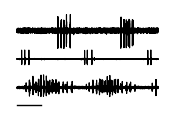

In [19]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1,figsize=(2.0, 1.3)) # (2.87, 2.08*3/4)
    ax.plot(t[start_index:end_index], 7.5+pdn[start_index:end_index]/np.max(pdn), c="k", lw=0.8)
    ax.plot(t[start_index:end_index], 6.25+lpn[start_index:end_index]/2.5/np.max(lpn), c="k", lw=0.8)
    ax.plot(t[start_index:end_index], 5+pyn[start_index:end_index]/1.2/np.max(pyn), c="k", lw=0.8)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_xaxis().set_ticks([])
    ax.get_yaxis().set_visible(False)

    duration = 0.5
    number_of_timesteps = int(duration / dt)
    t_scale = np.linspace(t[start_index], t[start_index + number_of_timesteps], 2)

    ax.plot(t_scale, 4.3 * np.ones_like(t_scale), c='k', lw=1.0)

    plt.savefig(PANEL_A, facecolor='None', transparent=True)
    plt.show()

# Panel C: posterior

/home/michael/Documents/sbi/sbi/utils/plot.py:205: UserWarning: You passed an argument `fig_size`. Since sbi v0.15.0, the argument should be called `figsize`. In future versions, `fig_size` will no longer be supported.
  warn(
/home/michael/Documents/sbi/sbi/utils/plot.py:563: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts["labels"] == [] or opts["labels"] is None:


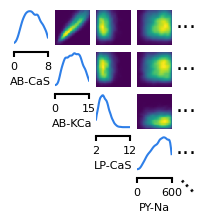

In [20]:
import matplotlib.patheffects as pe

with mpl.rc_context(fname='../../../.matplotlibrc'):

    labels_ = get_labels_8pt()
    labels_[9] += ''

    fig, axes = pairplot(samples=[theta_np[:10000]],
                           subset=[2,4,10, 16],
                           limits=lims,
                           ticks=lims,
                           fig_size=(17.0*0.12, 17.0*0.12),
                           labels=labels_,
                           scatter_offdiag={'rasterized':True, 'alpha':1.0},
                           samples_colors=[col['SNPE']],
                           diag=['kde'],
                           upper=['kde'],
                           hist_offdiag={'bins':50},
                           plot_offdiag={'linewidth': 1.6, 'path_effects':[pe.Stroke(linewidth=2.4, foreground='k'), pe.Normal()]})

#     plt.savefig(PANEL_B, facecolor='None', transparent=True)
    plt.show()

# Panel D: posterior samples

In [21]:
time_vec = np.arange(0, 11000, 0.025)

In [22]:
trace_posterior = simulate(theta.loc[0], seed=int(seeds[0]))

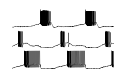

In [23]:
fig, ax = plt.subplots(1,1,figsize=(2.0,1.2))
viz.vis_sample_plain(
    voltage_trace=trace_posterior,
    t=time_vec,
    axV=ax,
    time_len=int(time_len),
    offset=60000,
    col="k",
    scale_bar=False,
    scale_bar_voltage=False,
    print_label=False,
)
plt.savefig(PANEL_B, facecolor='None', transparent=True, dpi=300, bbox_inches='tight')
plt.show()

# Histograms

In [24]:
all_energies_per_spike = x["energies_per_spike"].to_numpy()
all_total_energies = x["energies"].to_numpy()

In [25]:
summed_energies_per_spike = np.sum(np.asarray(all_energies_per_spike), axis=1)
summed_energies_total = np.sum(np.asarray(all_total_energies), axis=1)

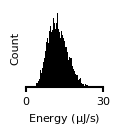

In [26]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.0, 1.0))

#     # / 10 because of 10 seconds simulation_time. /1000 to go from nJ to muJ
#     _ = ax[0].hist(
#         all_total_energies[:, 0]/10/1000, range=[0, 30], bins=100, color="#3182bd"
#     )
#     ax[0].set_ylabel("Count")
#     ax[0].tick_params(axis="both", which="major")
#     ax[0].spines["top"].set_visible(False)
#     ax[0].spines["right"].set_visible(False)
#     ax[0].spines["left"].set_visible(False)
#     ax[0].axes.get_yaxis().set_ticks([])
#     ax[0].set_title("AB/PD")

#     _ = ax[1].hist(
#         all_total_energies[:, 1]/10/1000, range=[0, 30], bins=100, color="#fc8d59"
#     )
#     # ax[1].set_ylabel('Count')
#     ax[1].tick_params(axis="both", which="major")
#     ax[1].spines["top"].set_visible(False)
#     ax[1].spines["right"].set_visible(False)
#     ax[1].spines["left"].set_visible(False)
#     ax[1].axes.get_yaxis().set_ticks([])
#     ax[1].set_title("LP")

#     _ = ax[2].hist(
#         all_total_energies[:, 2]/10/1000, range=[0, 30], bins=100, color="#2ca25f"
#     )
#     # ax[2].set_ylabel('Count')
#     ax[2].tick_params(axis="both", which="major")
#     ax[2].spines["top"].set_visible(False)
#     ax[2].spines["right"].set_visible(False)
#     ax[2].spines["left"].set_visible(False)
#     ax[2].axes.get_yaxis().set_ticks([])
#     ax[2].set_title("PY")

    _ = ax.hist(summed_energies_total/10/1000, range=[0, 30], bins=100, color="k")
    # ax[3].set_ylabel('Count')
    ax.tick_params(axis="both", which="major")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.axes.get_yaxis().set_ticks([])
#     ax.set_title("Sum")

    plt.subplots_adjust(wspace=0.3)

    ax.set_xlim([0, 30])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_xlabel("Energy ($\mu$J/s)")
    ax.set_xticks([0, 30])
    ax.set_ylabel("Count")

    plt.savefig(PANEL_C, facecolor="None", transparent=True)
    plt.show()

In [27]:
print("min and max differ by:  ", np.max(summed_energies_total/10/1000) / np.min(summed_energies_total/10/1000))

min and max differ by:   9.179786456831717


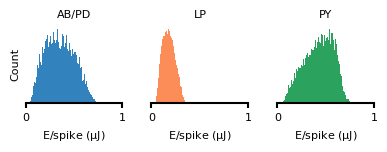

In [28]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 3, figsize=(4.5, 1))

    # The factor /4000 comes from: 10 second recording. 0.025ms stepsize -> total energy = int_energy = energy * 0.025ms = energy / 40000
    _ = ax[0].hist(all_energies_per_spike[:, 0] / 1000, range=[0, 1], bins=100, color="#3182bd")
    ax[0].set_ylabel("Count")
    ax[0].axes.get_yaxis().set_ticks([])
    ax[0].set_title("AB/PD")

    _ = ax[1].hist(
        all_energies_per_spike[:, 1] / 1000, range=[0, 1], bins=100, color="#fc8d59"
    )
    # ax[1].set_ylabel('Count')
    ax[1].set_xlabel("E/spike")
    ax[1].axes.get_yaxis().set_ticks([])
    ax[1].set_title("LP")

    _ = ax[2].hist(all_energies_per_spike[:, 2] / 1000, range=[0, 1], bins=100, color="#2ca25f")
    # ax[2].set_ylabel('Count')
    ax[2].set_xlabel("E/spike")
    ax[2].axes.get_yaxis().set_ticks([])
    ax[2].set_title("PY")

    for i in range(3):
        ax[i].set_xlim([0, 1])
        ax[i].set_xticks([0, 1])
        ax[i].set_xlabel("E/spike ($\mu$J)")
        ax[i].spines["top"].set_visible(False)
        ax[i].spines["right"].set_visible(False)
        ax[i].spines["left"].set_visible(False)

    plt.subplots_adjust(wspace=0.3)

#     plt.savefig(PANEL_I, facecolor="None", transparent=True)
    plt.show()

# Fig 3

In [29]:
import sys
from sbi.utils import user_input_checks_utils

sys.modules["sbi.user_input.user_input_checks_utils"] = user_input_checks_utils

In [30]:
with open(
    "../../../results/trained_neural_nets/inference/posterior_11deg.pickle", "rb"
) as handle:
    posterior = pickle.load(handle)
    posterior._device = 'cpu'
    posterior._sample_with = "rejection"

/home/michael/Documents/sbi/sbi/inference/posteriors/base_posterior.py:1130: UserWarning: You had saved the posterior under an older version of `sbi`. To make the loaded version comply with the version you are using right now, we had to set the following attributes: `self._device = cpu` `self._num_iid_trials = None` `self._iid_methods = ['snle', 'snre_a', 'snre_b']` `self._allow_iid_x = False` `self._sample_with = rejection`
  warn(warning_description + warning_msg)


In [31]:
energies = x["energies"]

In [32]:
energies_tt = torch.as_tensor(energies.to_numpy())
x_tt = torch.as_tensor(x_np, dtype=torch.float32)

In [33]:
num_test = 500

test_params = theta_np[:num_test]
train_params = theta_np[num_test:]
mean_params = np.mean(train_params, axis=0)
std_params = np.std(train_params, axis=0)

train_params_norm = (train_params - mean_params) / std_params
test_params_norm = (test_params - mean_params) / std_params

In [34]:
train_energy_ABPD = torch.sum(torch.as_tensor(energies.to_numpy())[num_test:], dim=1).unsqueeze(1)
test_energy_ABPD = torch.sum(torch.as_tensor(energies.to_numpy())[:num_test], dim=1).unsqueeze(1)
mean_energy = torch.mean(train_energy_ABPD)
std_energy = torch.std(train_energy_ABPD)
train_energy_ABPD_norm = (train_energy_ABPD - mean_energy) / std_energy
test_energy_ABPD_norm = (test_energy_ABPD - mean_energy) / std_energy

regressor = LinearRegression()
fitted_reg = regressor.fit(train_params_norm, train_energy_ABPD_norm)
predictions = fitted_reg.predict(test_params_norm)
coeff = np.asarray([fitted_reg.coef_[0]])
coeff = coeff / np.linalg.norm(coeff)

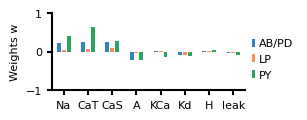

In [35]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz3.py_sensitivity_bars_cosyne(
        torch.as_tensor(coeff)[0],
        ylim=[-1, 1.0],
        figsize=(2.5, 1.0),
        ylabel="Weights w",
        plot_labels=True,
        title=None,
    )
    plt.savefig(PANEL_D, facecolor="None", transparent=True)
    plt.show()

# Assemble figure

In [36]:
color_mixture1 = 0.33 * np.asarray(list(col['CONSISTENT1'])) + 0.67 * np.asarray(
    list(col['CONSISTENT2']))
color_mixture2 = 0.67 * np.asarray(list(col['CONSISTENT1'])) + 0.33 * np.asarray(
    list(col['CONSISTENT2']))

In [37]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [38]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

startx1 = 492
startx2 = 594
starty1 = 204
starty2 = 307

endx1 = 642
endx2 = 673
endy1 = 159
endy2 = 191

deltax1 =  endx1-startx1
deltax2 =  endx2-startx2
deltay1 =  endy1-starty1
deltay2 =  endy2-starty2

sizefactor = 1.0
dshift = 0.5*factor_svg

f = Figure("20.3cm", "3.2cm",

    Panel(
          SVG(PANEL_A).scale(svg_scale*1.03).move(0*factor_svg, 0*factor_svg),
          Text("a", -2*factor_svg, 2.3*factor_svg-dshift, **kwargs_text),
        Text("PD", -1.*factor_svg, 6.0*factor_svg, **kwargs_text8pt),
        Text("LP", -1.*factor_svg, 10.8*factor_svg, **kwargs_text8pt),
        Text("PY", -1.*factor_svg, 15.8*factor_svg, **kwargs_text8pt),
    ).move(2*factor_svg, 0*factor_svg+dshift),

    Panel(
        SVG(PANEL_B).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("b", 0.0*factor_svg, 1.8*factor_svg-dshift, **kwargs_text),
    ).move(33.0*factor_svg, 0.5*factor_svg+dshift),

    Panel(
          SVG(PANEL_C).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
          Text("c", -0*factor_svg, 1.1*factor_svg-dshift, **kwargs_text),
    ).move(67*factor_svg, 1.2*factor_svg+dshift),

    Panel(
          SVG(PANEL_D).scale(svg_scale).move(-10*factor_svg,0*factor_svg),
          Text("d", -10.5*factor_svg, 1.9*factor_svg-dshift, **kwargs_text),
    ).move(99.5*factor_svg, 0.4*factor_svg+dshift),

)

!mkdir -p fig
f.save("../fig/prep078_summ1.svg")
svg('../fig/prep078_summ1.svg')